In [1]:
import math
import matplotlib.pyplot as plt
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

from critic_config import make_critic
from models import *
from utils_training import *
from utils_data_generator import *
from utils import *
from config_defaults import CRITIC_DEFAULTS, DATASET_DEFAULTS
from h5_result_store import H5ResultStore
import torch
import numpy as np
import random

def create_teacher_models_symmetric(input_dim: int, output_dim: int, device='cuda'):
    teacher_model_x = teacher(dz=input_dim, output_dim=output_dim)
    teacher_model_y = teacher(dz=input_dim, output_dim=output_dim)

    teacher_model_x = teacher_model_x.to(device)
    teacher_model_y = teacher_model_y.to(device)

    for param_x in teacher_model_x.parameters():
        param_x.requires_grad_(False)  # Freeze
    for param_y in teacher_model_y.parameters():
        param_y.requires_grad_(False)

    return teacher_model_x, teacher_model_y



## TO-DO: Add argparse to do this systematically when calling the run file from a job
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_single_experiment_dsib_infinite(
    estimator: str = "lclip",
    critic_type = "hybrid",
    batch_size=128,
    n_iter=2000,
    dataset_type = "gaussian_mixture",
    seed = None,
    outfile = "h5_results/test_output.h5",
    optimizer_cls=torch.optim.Adam, 
    lr=5e-4, 
    optimizer_kwargs=None, 
    cfg_user_dataset=None,  #override options 
    cfg_user_critic= None,  #override options
    show_progress = True, 
    device = 'cuda'
):
    ## initialize seed
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1) # log this seed in the h5 output and other trianing parameters

    set_seed(seed)

    # create dataset and critic configurations: override defaults with user inputs
    dataset_cfg = DATASET_DEFAULTS[dataset_type]
    if cfg_user_dataset:
        dataset_cfg.update(cfg_user_dataset)

    critic_cfg = CRITIC_DEFAULTS[critic_type]
    if cfg_user_critic:
        critic_cfg.update(cfg_user_critic)

    dataset_latent_dim = dataset_cfg["latent_dim"]
    if dataset_cfg["observe_dim_x"] == dataset_cfg["observe_dim_y"]:
        dataset_observe_dim = dataset_cfg["observe_dim_x"]
    else:
        raise ValueError(f"Output dim_x != Ouput dim_y, currently set up for a symmetric case only")    
    
    teacher_model_x, teacher_model_y = create_teacher_models_symmetric(input_dim = dataset_latent_dim, output_dim = dataset_observe_dim, device=device)

    ##################################    

    critic, critic_params, critic_tags = make_critic(critic_type, **critic_cfg) 
    data_generator = make_data_generator(dataset_type, dataset_cfg, teacher_model_x, teacher_model_y)

    model = DSIB(estimator=estimator, critic=critic)
    
    ################TRAINING###########################
    
    estimates_mi = train_model_infinite_data(model, data_generator, batch_size, n_iter, show_progress=show_progress, optimizer_cls=optimizer_cls, lr=lr, optimizer_kwargs=optimizer_kwargs, device=device)  
    # returns -mi in nats
    mis_dsib_bits = -np.array(estimates_mi)*np.log2(np.e)            

    ##############SAVE_OUTPUTS#############################

    tags={
        "method": "dsib",
        "critic_type": critic_type,
        "dataset_type": dataset_type,
        "estimator": estimator,

        "kz": critic_cfg["embed_dim"],
        "batch_size": batch_size,
        "n_iter": n_iter,           
    }

    params={
        "method": "dsib",
        "critic_type": critic_type,
        "critic_cfg": critic_cfg,
        "critic_params": critic_params,

        "dataset_type": dataset_type,
        "dataset_cfg": dataset_cfg,
        "dataset_embed":"teacher",

        "training_cfg": {
            "setup": "infinite_data_iter",
            "estimator": estimator, 
            "batch_size": batch_size,
            "n_iter": n_iter,
            "optimizer": optimizer_cls.__name__,
            "lr": lr,
            "seed": seed,
        },
    }

    with H5ResultStore(outfile) as rs:        
        rid = rs.new_run(params=params, tags=tags, dedupe_on_fingerprint=False)
        rs.save_array(rid, "mi_bits", mis_dsib_bits)

    return mis_dsib_bits



/users/pgulat4/.conda/envs/MI_estimation/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:

def run_parameter_sweep():
    outfile = "h5_results/testing_a.h5"
    
    dataset_type = "gaussian_mixture"
    ##override defaults
    cfg_user_dataset = dict(n_peaks=8, mu=2.0, sig=1.0, mi_bits_peak=2.0, sig_embed=0.0, noise_mode="white_relative", latent_dim=1, observe_dim_x=500, observe_dim_y=500)

    n_iter=2000
    num_trials = 1
    kz_list = range(2)
    
    for trial_num in range(num_trials):
        for kz in kz_list:
            for critic_type in ["hybrid", "separable"]:

                if critic_type == "hybrid" and kz == 0:
                    continue  

                cfg_user_critic = {"embed_dim": kz}
    
                mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')



In [27]:
run_parameter_sweep()

100%|██████████| 2000/2000 [00:05<00:00, 366.83it/s]


Run with kz = 0, critic_type: separable;  dataset_type: gaussian_mixture; Saved to h5_results/testing_a.h5


100%|██████████| 2000/2000 [00:06<00:00, 286.19it/s]


Run with kz = 1, critic_type: hybrid;  dataset_type: gaussian_mixture; Saved to h5_results/testing_a.h5


100%|██████████| 2000/2000 [00:05<00:00, 352.80it/s]

Run with kz = 1, critic_type: separable;  dataset_type: gaussian_mixture; Saved to h5_results/testing_a.h5


In [24]:

def run_parameter_sweep():
    outfile = "h5_results/testing_b.h5"
    
    dataset_type = "joint_gaussian"
    ##override defaults
    cfg_user_dataset = dict(mi_bits=2.0, latent_dim=8)

    n_iter=2000
    num_trials = 1
    kz_list = range(8,12,1)
    
    for trial_num in range(num_trials):
        for kz in kz_list:
            for critic_type in ["hybrid", "separable"]:

                if critic_type == "hybrid" and kz == 0:
                    continue  

                cfg_user_critic = {"embed_dim": kz}

                print(cfg_user_dataset)
    
                mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')



In [25]:
run_parameter_sweep()

{'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 2000/2000 [00:06<00:00, 301.09it/s]


Run with kz = 10, critic_type: hybrid;  dataset_type: joint_gaussian; Saved to h5_results/testing_b.h5
{'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 2000/2000 [00:05<00:00, 363.47it/s]

Run with kz = 10, critic_type: separable;  dataset_type: joint_gaussian; Saved to h5_results/testing_b.h5


In [30]:

def run_parameter_sweep():
    outfile = "h5_results/testing_c.h5"
    
    dataset_type = "ring_with_spread"
    ##override defaults
    cfg_user_dataset = {}

    n_iter=2000
    num_trials = 1
    kz_list = range(5)
    
    for trial_num in range(num_trials):
        for kz in kz_list:
            for critic_type in ["hybrid", "separable"]:

                if critic_type == "hybrid" and kz == 0:
                    continue  

                cfg_user_critic = {"embed_dim": kz}

                print(cfg_user_dataset)
    
                mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')



In [31]:
run_parameter_sweep()

{}


100%|██████████| 2000/2000 [00:04<00:00, 453.83it/s]


Run with kz = 0, critic_type: separable;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:06<00:00, 331.29it/s]


Run with kz = 1, critic_type: hybrid;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:04<00:00, 428.66it/s]


Run with kz = 1, critic_type: separable;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:05<00:00, 334.22it/s]


Run with kz = 2, critic_type: hybrid;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:04<00:00, 421.78it/s]


Run with kz = 2, critic_type: separable;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:05<00:00, 338.02it/s]


Run with kz = 3, critic_type: hybrid;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:04<00:00, 428.16it/s]


Run with kz = 3, critic_type: separable;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:05<00:00, 336.03it/s]


Run with kz = 4, critic_type: hybrid;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5
{}


100%|██████████| 2000/2000 [00:04<00:00, 409.68it/s]


Run with kz = 4, critic_type: separable;  dataset_type: ring_with_spread; Saved to h5_results/testing_c.h5


In [48]:

def run_parameter_sweep():
    outfile = "h5_results/testing_b_hp.h5"
    
    dataset_type = "joint_gaussian"
    ##override defaults
    cfg_user_dataset = dict(mi_bits=2.0, latent_dim=8)

    num_trials = 3
    kz = 6
    critic_type = "hybrid"

    
    pair_layers = [1]
    pair_sizes = [16]

    encode_layers = [2, 4]
    hidden_sizes = [256, 512]

    lr_s = [0.0001]
    n_iter= 20_000 

    for trial_num in range(num_trials):
        print(trial_num)
        for lr in lr_s:
            for pair_layer in pair_layers:
                for encode_layer in encode_layers:
                    for hidden_size in hidden_sizes:
                        for pair_size in pair_sizes:
                    
                            if critic_type == "hybrid" and kz == 0:
                                continue  
                    
                            cfg_user_critic = dict(embed_dim=kz, x_hidden_dim=hidden_size, x_layers=encode_layer, y_hidden_dim=hidden_size, y_layers=encode_layer, pair_hidden_dim=pair_size, pair_layers=pair_layer)
                    
                            mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter, lr=lr, show_progress= True)
                    
                            print(f'Run completed; saved to {outfile}; Override parameters: lr = {lr}, {cfg_user_critic}, {cfg_user_dataset}')

    return mis_dsib_bits


In [49]:
mis_dsib_bits = run_parameter_sweep()

0


100%|██████████| 20000/20000 [01:09<00:00, 289.50it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 256, 'x_layers': 2, 'y_hidden_dim': 256, 'y_layers': 2, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:09<00:00, 287.12it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 512, 'x_layers': 2, 'y_hidden_dim': 512, 'y_layers': 2, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:21<00:00, 245.47it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 256, 'x_layers': 4, 'y_hidden_dim': 256, 'y_layers': 4, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:23<00:00, 239.83it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 512, 'x_layers': 4, 'y_hidden_dim': 512, 'y_layers': 4, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}
1


100%|██████████| 20000/20000 [01:08<00:00, 290.27it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 256, 'x_layers': 2, 'y_hidden_dim': 256, 'y_layers': 2, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:10<00:00, 285.68it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 512, 'x_layers': 2, 'y_hidden_dim': 512, 'y_layers': 2, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:21<00:00, 246.13it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 256, 'x_layers': 4, 'y_hidden_dim': 256, 'y_layers': 4, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}


100%|██████████| 20000/20000 [01:23<00:00, 238.67it/s]


Run completed; saved to h5_results/testing_b_hp.h5; Override parameters: lr = 0.0001, {'embed_dim': 6, 'x_hidden_dim': 512, 'x_layers': 4, 'y_hidden_dim': 512, 'y_layers': 4, 'pair_hidden_dim': 16, 'pair_layers': 1}, {'mi_bits': 2.0, 'latent_dim': 8}
2


 30%|███       | 6008/20000 [00:20<00:48, 291.35it/s]


KeyboardInterrupt: 

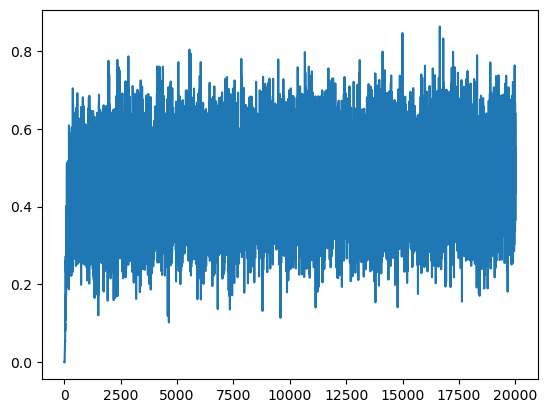

In [50]:
import matplotlib.pyplot as plt
plt.plot(mis_dsib_bits)

In [4]:
def run_parameter_sweep():
    outfile = "h5_results/testing_d.h5"
    
    dataset_type = "hyperspherical_shell"
    ##override defaults

    num_trials = 1
    n_iter=20000
    kz_list = range(4)
    
    for trial_num in range(num_trials):        
        for latent_dim in [1]:        
            for sig_embed in [2.0]: 
                cfg_user_dataset = {"sig_embed":sig_embed, "latent_dim":latent_dim}
            
                for kz in kz_list:
                    for critic_type in ["hybrid", "separable"]:
        
                        if critic_type == "hybrid" and kz == 0:
                            continue  
        
                        cfg_user_critic = {"embed_dim": kz}
        
                        print(f'Override parameters: {cfg_user_dataset}')
            
                        mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                        print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')
                        

In [5]:
run_parameter_sweep()

Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [00:46<00:00, 430.56it/s]


Run with kz = 0, critic_type: separable;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [01:02<00:00, 321.38it/s]


Run with kz = 1, critic_type: hybrid;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [00:49<00:00, 401.84it/s]


Run with kz = 1, critic_type: separable;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [01:01<00:00, 325.70it/s]


Run with kz = 2, critic_type: hybrid;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [00:48<00:00, 413.27it/s]


Run with kz = 2, critic_type: separable;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [01:01<00:00, 325.05it/s]


Run with kz = 3, critic_type: hybrid;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5
Override parameters: {'sig_embed': 2.0, 'latent_dim': 1}


100%|██████████| 20000/20000 [00:48<00:00, 409.37it/s]

Run with kz = 3, critic_type: separable;  dataset_type: hyperspherical_shell; Saved to h5_results/testing_d.h5


In [10]:
def run_parameter_sweep():
    outfile = "h5_results/testing_e.h5"
    
    dataset_type = "swiss_roll"
    ##override defaults

    num_trials = 1
    n_iter=20000
    kz_list = range(6)
    
    for trial_num in range(num_trials):  
        for sig_embed in [2.0, 5.0]:
            
            cfg_user_dataset = {"sig_embed":sig_embed, "t_min_pi_units":1.5, "t_max_pi_units":3.5} # override parameters
        
            for kz in kz_list:
                for critic_type in ["hybrid", "separable"]:
        
                    if critic_type == "hybrid" and kz == 0:
                        continue  
        
                    cfg_user_critic = {"embed_dim": kz}
        
                    print(f'Override parameters: {cfg_user_dataset}')
        
                    mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                    print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')
                    

In [11]:
run_parameter_sweep()

Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:46<00:00, 431.78it/s]


Run with kz = 0, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:02<00:00, 317.70it/s]


Run with kz = 1, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:49<00:00, 403.28it/s]


Run with kz = 1, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 323.87it/s]


Run with kz = 2, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:48<00:00, 409.52it/s]


Run with kz = 2, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 325.59it/s]


Run with kz = 3, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:49<00:00, 400.89it/s]


Run with kz = 3, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 324.88it/s]


Run with kz = 4, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:49<00:00, 405.93it/s]


Run with kz = 4, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:02<00:00, 321.78it/s]


Run with kz = 5, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:48<00:00, 411.61it/s]


Run with kz = 5, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:46<00:00, 430.16it/s]


Run with kz = 0, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:02<00:00, 321.16it/s]


Run with kz = 1, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:49<00:00, 405.38it/s]


Run with kz = 1, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 325.42it/s]


Run with kz = 2, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:48<00:00, 409.04it/s]


Run with kz = 2, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 325.80it/s]


Run with kz = 3, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:49<00:00, 407.81it/s]


Run with kz = 3, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 325.37it/s]


Run with kz = 4, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:48<00:00, 408.84it/s]


Run with kz = 4, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [01:01<00:00, 325.38it/s]


Run with kz = 5, critic_type: hybrid;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5
Override parameters: {'sig_embed': 5.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


100%|██████████| 20000/20000 [00:48<00:00, 411.92it/s]

Run with kz = 5, critic_type: separable;  dataset_type: swiss_roll; Saved to h5_results/testing_e.h5


In [1]:
from ..critic_config import make_critic
from ..models import *
from ..utils_training import *
from ..utils_data_generator import *
from ..utils import *
import math
import matplotlib.pyplot as plt
from ..config_defaults import CRITIC_DEFAULTS, DATASET_DEFAULTS
from ..h5_result_store import H5ResultStore
import torch
import numpy as np
import random
import copy


from utils.utils_version import get_git_commit_hash, is_dirty, get_git_diff

## TO-DO: Add argparse to do this systematically when calling the run file from a job
## TO-DO: Make dataclasses to keep track of all parameters for an experiment, maybe called experimentConfig, basically group all the loose parameters and separate dictionaries into one


def create_teacher_models_symmetric(input_dim: int, output_dim: int, device='cuda'):
    teacher_model_x = teacher(dz=input_dim, output_dim=output_dim)
    teacher_model_y = teacher(dz=input_dim, output_dim=output_dim)

    teacher_model_x = teacher_model_x.to(device)
    teacher_model_y = teacher_model_y.to(device)

    for param_x in teacher_model_x.parameters():
        param_x.requires_grad_(False)  # Freeze
    for param_y in teacher_model_y.parameters():
        param_y.requires_grad_(False)

    return teacher_model_x, teacher_model_y



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)



def run_single_experiment_dsib_infinite(
    estimator: str = "lclip",
    critic_type = "hybrid",
    batch_size=128,
    n_iter=2000,
    dataset_type = "gaussian_mixture",
    seed = None,
    outfile = "h5_results/test_output.h5",
    optimizer_cls=torch.optim.Adam, 
    lr=5e-4, 
    optimizer_kwargs=None, 
    cfg_user_dataset=None,  #override options 
    cfg_user_critic= None,  #override options
    show_progress = True, 
    device = 'cuda'
):
    ## initialize seed
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1) # log this seed in the h5 output and other trianing parameters

    set_seed(seed)

    # create dataset and critic configurations: override defaults with user inputs
    dataset_cfg = copy.deepcopy(DATASET_DEFAULTS[dataset_type])
    if cfg_user_dataset:
        dataset_cfg.update(cfg_user_dataset)

    critic_cfg = copy.deepcopy(CRITIC_DEFAULTS[critic_type])
    if cfg_user_critic:
        critic_cfg.update(cfg_user_critic)

    dataset_latent_dim = dataset_cfg["latent_dim"]
    if dataset_cfg["observe_dim_x"] == dataset_cfg["observe_dim_y"]:
        dataset_observe_dim = dataset_cfg["observe_dim_x"]
    else:
        raise ValueError(f"Output dim_x != Ouput dim_y, currently set up for a symmetric case only")    
    
    teacher_model_x, teacher_model_y = create_teacher_models_symmetric(input_dim = dataset_latent_dim, output_dim = dataset_observe_dim, device=device)

    ##################################    

    critic, critic_params, critic_tags = make_critic(critic_type, **critic_cfg) 
    data_generator = make_data_generator(dataset_type, dataset_cfg, teacher_model_x, teacher_model_y)

    model = DSIB(estimator=estimator, critic=critic)
    
    ################TRAINING###########################
    
    estimates_mi = train_model_infinite_data(model, data_generator, batch_size, n_iter, show_progress=show_progress, optimizer_cls=optimizer_cls, lr=lr, optimizer_kwargs=optimizer_kwargs, device=device)  
    # returns -mi in nats
    mis_dsib_bits = -np.array(estimates_mi)*np.log2(np.e)            

    ##############SAVE_OUTPUTS#############################

    code_meta = {
    "git_commit": get_git_commit_hash(),
    "dirty": is_dirty(),
    }

    if code_meta["dirty"]:
        code_meta["dirty_diff"] = get_git_diff()

    tags={
        "method": "dsib",
        "critic_type": critic_type,
        "dataset_type": dataset_type,
        "estimator": estimator,

        "kz": critic_cfg.get("embed_dim", None),
        "batch_size": batch_size,
        "n_iter": n_iter,           
    }

    params={
        "method": "dsib",
        "critic_type": critic_type,
        "critic_cfg": critic_cfg,
        "critic_params": critic_params,

        "dataset_type": dataset_type,
        "dataset_cfg": dataset_cfg,
        "dataset_embed":"teacher",

        "training_cfg": {
            "setup": "infinite_data_iter",
            "estimator": estimator, 
            "batch_size": batch_size,
            "n_iter": n_iter,
            "optimizer": optimizer_cls.__name__,
            "lr": lr,
            "seed": seed,
        },
        "code": code_meta,
    }

    with H5ResultStore(outfile) as rs:        
        rid = rs.new_run(params=params, tags=tags, dedupe_on_fingerprint=False)
        rs.save_array(rid, "mi_bits", mis_dsib_bits)

    return mis_dsib_bits


# if __name__=="__main__":
#     run_parameter_sweep()



ImportError: attempted relative import with no known parent package

In [3]:
def run_parameter_sweep():
    outfile = "../h5_results/testing_code_version_history.h5"
    
    dataset_type = "swiss_roll"
    ##override defaults

    num_trials = 1
    n_iter=2000
    kz_list = range(3)
    
    for trial_num in range(num_trials):  
        for sig_embed in [2.0, 5.0]:
            
            cfg_user_dataset = {"sig_embed":sig_embed, "t_min_pi_units":1.5, "t_max_pi_units":3.5} # override parameters
        
            for kz in kz_list:
                for critic_type in ["hybrid", "separable"]:
        
                    if critic_type == "hybrid" and kz == 0:
                        continue  
        
                    cfg_user_critic = {"embed_dim": kz}
        
                    print(f'Override parameters: {cfg_user_dataset}')
        
                    mis_dsib_bits = run_single_experiment_dsib_infinite(critic_type = critic_type, outfile=outfile, dataset_type=dataset_type, cfg_user_dataset = cfg_user_dataset, cfg_user_critic=cfg_user_critic, n_iter=n_iter)
                    print(f'Run with kz = {kz}, critic_type: {critic_type};  dataset_type: {dataset_type}; Saved to {outfile}')
                    

In [4]:
run_parameter_sweep()

Override parameters: {'sig_embed': 2.0, 't_min_pi_units': 1.5, 't_max_pi_units': 3.5}


NameError: name 'copy' is not defined